In [2]:
n_mfcc = 64
n_mfcc_width = 432
window_size = 10
audio_len = 150
data_dir = 'audio-train-new'
n_samples = 118

In [9]:
import librosa as lp
import matplotlib.pyplot as plt
import numpy as np
import os
import subprocess
import shutil
from scikits.talkbox import lpc


def convert_to_lpc(filename,number_of_coefficients):
    wave, sr = lp.load(filename, mono=True, sr=None)
    lpc_signal=lpc(wave,number_of_coefficients)
#     print lpc_signal[0].shape, lpc_signal[1].shape, lpc_signal[2].shape
#     print lpc_signal
#     lpcc_signal=lpcc(lpc_signal[0],lpc_signal[1])
#     print lpc_signal.shape
    return np.hstack((lpc_signal[0],lpc_signal[1],lpc_signal[2]))
                    

def lpcc(seq, err_term, order=None):
    if order is None:
        order = len(seq) - 1
    lpcc_coeffs = [np.log(err_term), -seq[0]]
    for n in xrange(2, order + 1):
        # Use order + 1 as upper bound for the last iteration
        upbound = (order + 1 if n > order else n)
        lpcc_coef = -sum(i * lpcc_coeffs[i] * seq[n - i - 1]
                         for i in xrange(1, upbound)) * 1. / upbound
        lpcc_coef -= seq[n - 1] if n <= len(seq) else 0
        lpcc_coeffs.append(lpcc_coef)
    return lpcc_coeffs


def run_preprocess(root, length, split):
    for subdir, dirs, files in os.walk(root):
        for directory in dirs:
            print(directory)
            lpcc_data = []
            mfcc_data = []
            npy_file_lp = directory + '_' + 'lpcc' + '.npy'
            npy_file_mf = directory + '_' + 'mfcc' + '_' + length + '_' + split + '.npy'
            if os.path.isfile(os.path.join(subdir, directory, npy_file_lp)) \
                    and os.path.isfile(os.path.join(subdir, directory, npy_file_mf)):
                continue

            if not os.path.isdir(os.path.join(subdir, directory, "split", split)):
                subprocess.call(["./preprocess", os.path.join(subdir, directory), length, split])

            file_path = os.path.join(subdir, directory, "split", split, "wav")
            for filename in os.listdir(file_path):
                lpcc_data.append(convert_to_lpc(os.path.join(file_path, filename), 49))
                y, sr = lp.load(os.path.join(file_path, filename))
                mfcc = lp.feature.mfcc(y = y, sr = 16000, n_mfcc = 128)
                mfcc = np.pad(mfcc, pad_width=((0, 0), (0, n_mfcc_width)), mode='constant')
                if mfcc.shape != (n_mfcc, n_mfcc_width):
                    mfcc = mfcc[:, :n_mfcc_width]
                mfcc_data.append(mfcc)

            if np.asarray(lpcc_data).shape[0] == 0:
                continue
            np.save(os.path.join(subdir, directory, npy_file_lp), np.asarray(lpcc_data))
            np.save(os.path.join(subdir, directory, npy_file_mf), np.asarray(mfcc_data))
            shutil.rmtree(os.path.join(subdir, directory, "split"), ignore_errors = True)
#             print(np.asarray(lpcc_data).shape)
        break
            


In [47]:
import shutil

def rename_npy(root, length, split):
    for subdir, dirs, files in os.walk(root):
        for directory in dirs:
            npy_file = directory + '_' + length + '_' + split + '.npy'
            new_npy_file = directory + '_' + 'mfcc' + '_' + str(512) + '_' + length + '_' + split + '.npy'
            if os.path.isfile(os.path.join(subdir, directory, npy_file)):
                shutil.move(os.path.join(subdir, directory, npy_file), os.path.join(subdir, directory, new_npy_file))
        break

In [54]:
def load_features(root):
    lpcc_data=[]
    mfcc_data = np.zeros((0, n_mfcc, n_mfcc_width))
    label = []
    for subdir, dirs, files in os.walk(root):
        count = 0
        for directory in dirs:
            npy_file_lp = directory + '_' + 'lpcc' + '.npy'
            npy_file_mf = directory + '_' + 'mfcc' + '_' + str(audio_len) + '_' + str(window_size) + '.npy'
            
            if(count==0):
                lpcc_data= np.load(os.path.join(subdir, directory, npy_file_lp))
            else:
                lpcc=np.load(os.path.join(subdir, directory, npy_file_lp))
                lpcc_data=np.vstack((lpcc_data,lpcc))
            count+=1
            
            mfcc = np.load(os.path.join(subdir, directory, npy_file_mf))
            if mfcc.size == 0:
                continue
            mfcc_data = np.concatenate((mfcc_data, mfcc[:, :n_mfcc, :]))
            label += mfcc.shape[0] * [directory.split('.')[0]]
        break
    return lpcc_data, mfcc_data, label

In [6]:
def cleanup_split(root):
    for subdir, dirs, files in os.walk(root):
        for directory in dirs:
            shutil.rmtree(os.path.join(subdir, directory, "split"), ignore_errors = True)
        break

In [50]:
import glob

def cleanup_merged(root):
    for subdir, dirs, files in os.walk(root):
        for directory in dirs:
            for f in glob.glob(os.path.join(subdir, directory, "*_merged*.*")):
                os.remove(f)
        break

def cleanup_npy(root):
    for subdir, dirs, files in os.walk(root):
        for directory in dirs:
            for f in glob.glob(os.path.join(subdir, directory, "*.npy")):
                os.remove(f)
        break

In [51]:
def rename_samples(root):
    for subdir, dirs, files in os.walk(root):
        for directory in dirs:
            shutil.move(os.path.join(subdir, directory), os.path.join(subdir, directory.split("_")[0]))
        break

def remove_extra_samples(root):
    for subdir, dirs, files in os.walk(root):
        for directory in dirs:
            name_o = directory.split(".") 
            if len(name_o) == 2 and int(name_o[1]) > 10:
                shutil.rmtree(os.path.join(subdir, directory))
        break
    
def distribute_samples(root):
    for subdir, dirs, files in os.walk(root):
        for directory in dirs:
            if len(directory.split(".")) != 1:
                continue
            for d_subdir, d_dirs, d_files in os.walk(os.path.join(root, directory)):
                for i, sample in enumerate(d_files):
                    os.makedirs(os.path.join(subdir, directory + "." + str(i + 1)))
                    shutil.move(os.path.join(subdir, directory, sample), \
                                os.path.join(subdir, directory + "." + str(i + 1), sample))
                break
        remove_extra_samples(root)
        break
        
def combine_samples(root):
    for subdir, dirs, files in os.walk(root):
        for directory in dirs:
            if not os.path.isdir(os.path.join(subdir, directory.split(".")[0])):
                os.makedirs(os.path.join(subdir, directory.split(".")[0]))
            else:
                for f in glob.glob(os.path.join(subdir, directory.split(".")[0], "*.npy")):
                    os.remove(f)
                    shutil.rmtree(os.path.join(subdir, directory.split(".")[0], "split"), ignore_errors = True)
            for d_subdir, d_dirs, d_files in os.walk(os.path.join(root, directory)):
                mp3_files = glob.glob(os.path.join(subdir, directory, "*.mp3"))
                for i, sample in enumerate(mp3_files):
                    shutil.move(os.path.join(subdir, directory, os.path.basename(sample)), \
                                os.path.join(subdir, directory.split(".")[0], os.path.basename(sample)))
                if len(directory.split(".")) != 1:
                    shutil.rmtree(os.path.join(subdir, directory))
                break
        break

In [7]:
cleanup_split(data_dir)
# cleanup_npy(data_dir)
# rename_samples(data_dir)
# distribute_samples(data_dir)
# combine_samples(data_dir)
run_preprocess(data_dir, str(audio_len), str(window_size))

adventuresbobwhite
aequanimitas
agnesgreyversion3
airplaneflyinghandbookvol3
alondonlife
ancient
aprendizdeconspirador
aristotles
artofdivinecontentment
battle-pieces
boatsoftheglencarrig
bookofgoodcounsels
briefe
britishsubject
canti
childs
company
contes
country
curlyandfloppytwistytail
de
deepwoodstocivilization
dernier
door
dubrovsky
englishgirls
esau
essayoncriticism
experiences
explorersandtravellers
food
formation
franceatwar
greybeardsatplay
gullivers
hindu
his
historietas
historymathematics
how
human
jessejames
john
journal
konekgorbunok
lark
lebenssucher
letters
lifeofcarltonparker
little
littlebrothertothebear
littlefoldedhands
littleprincess
lob
marcia
marybartonversion2
mayorofcasterbridge3
meguriai
meister
miss
modern
moral
morallettersvol1
mounties
myreminiscences
mysteries
mystical
myths
nedfranks
new
onanirishjauntingcar
origin
pennycomequicks
philosophical
plateroyyo
psychologyofpeople
religiousaffections
republicofthefuture
reynardthefox
rose
roughriders
sabotage
sac

In [55]:
# from IPython.core.debugger import set_trace
X_lp, X_mf, y = load_features(data_dir)

In [79]:
from sklearn.model_selection import train_test_split

X = np.hstack((X_lp, X_mf.reshape(X_mf.shape[0], -1)))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=64)

z_train = np.hsplit(X_train, [X_lp.shape[1], X_mf.shape[0] * X_mf.shape[1]])
X_lp_train = z_train[0].reshape(z_train[0].shape[0], 10, -1, 1)
X_mf_train = z_train[1].reshape(z_train[1].shape[0], X_mf.shape[1], -1, 1)

z_test = np.hsplit(X_test, [X_lp.shape[1], X_mf.shape[0] * X_mf.shape[1]])
X_lp_test = z_test[0].reshape(z_test[0].shape[0], 10, -1, 1)
X_mf_test = z_test[1].reshape(z_test[1].shape[0], X_mf.shape[1], -1, 1)

In [58]:
import keras
import numpy as np
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

l_enc = LabelEncoder()
l_enc.fit(y_train)
y_train_enc = l_enc.transform(y_train)
y_train_norm = np_utils.to_categorical(y_train_enc)

l_enc.fit(y_test)
y_test_enc = l_enc.transform(y_test)
y_test_norm = np_utils.to_categorical(y_test_enc)

Using TensorFlow backend.


In [169]:
# del X, y, y_train_enc, y_test_enc, y_train, y_test
# X_train = X_train
# X_test = X_test
# X_r = X_test.reshape(X_test.shape[0], 5, -1, 1)
# X_r.shape

In [93]:
from keras.layers import Activation, Conv2D, Dense, Dropout, Flatten, Input, MaxPooling2D
from keras.models import Model, Sequential

model_lp = Sequential()
model_lp.add(Conv2D(32, kernel_size=(2, 2), activation='relu',
                 input_shape=(10, 10, 1)))
model_lp.add(MaxPooling2D(pool_size=(2, 2)))
model_lp.add(Activation('relu'))
model_lp.add(Dropout(0.25))

model_lp.add(Conv2D(32, kernel_size=(2, 2), padding='same'))
model_lp.add(Activation('relu'))
model_lp.add(MaxPooling2D(pool_size=(2, 2)))
model_lp.add(Dense(64))
model_lp.add(Dropout(0.25))
model_lp.add(Flatten())

input_lp = Input(shape=(10, 10, 1))
layer_lp = model_lp(input_lp)

model_mf = Sequential()
model_mf.add(Conv2D(32, kernel_size=(2, 2), activation='relu',
                 input_shape=(n_mfcc, n_mfcc_width, 1)))
model_mf.add(MaxPooling2D(pool_size=(2, 2)))
model_mf.add(Activation('relu'))
model_mf.add(Dropout(0.25))

model_mf.add(Conv2D(32, kernel_size=(2, 2), padding='same'))
model_mf.add(Activation('relu'))
model_mf.add(MaxPooling2D(pool_size=(2, 2)))
model_mf.add(Dense(n_mfcc/2, activation='relu'))
model_mf.add(Dropout(0.25))
model_mf.add(Flatten())

input_mf = Input(shape=(n_mfcc, n_mfcc_width, 1))
layer_mf = model_mf(input_mf)

merged = keras.layers.concatenate([layer_lp, layer_mf])
output = Dense(len(y_test_norm[0]), activation='softmax')(merged)

model = Model(inputs=[input_lp, input_mf], outputs=output)

# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
ctr = 1

In [63]:
from keras.utils import plot_model
plot_model(model, to_file='hybrid_model.png', show_shapes=True)

In [80]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 24, 0, 32)         160       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 12, 0, 32)         0         
_________________________________________________________________
activation_15 (Activation)   (None, 12, 0, 32)         0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 12, 0, 32)         0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 12, 0, 32)         4128      
_________________________________________________________________
activation_16 (Activation)   (None, 12, 0, 32)         0         
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 6, 0, 32)          0         
__________

In [94]:
train_result = model.fit([X_lp_train, X_mf_train], y_train_norm,
          batch_size=32,
          epochs=20,
          verbose=1,
          shuffle = True,
         validation_data=([X_lp_test, X_mf_test], y_test_norm))

Train on 1176 samples, validate on 504 samples
Epoch 1/20
1176/1176 [==============================] - 29s 25ms/step - loss: 15.7883 - acc: 0.0085 - val_loss: 15.9955 - val_acc: 0.0060
Epoch 2/20
1176/1176 [==============================] - 32s 27ms/step - loss: 15.5288 - acc: 0.0162 - val_loss: 15.2209 - val_acc: 0.0139
Epoch 3/20
1176/1176 [==============================] - 31s 26ms/step - loss: 15.3801 - acc: 0.0145 - val_loss: 14.3104 - val_acc: 0.0159
Epoch 4/20
1176/1176 [==============================] - 30s 26ms/step - loss: 14.4497 - acc: 0.0332 - val_loss: 12.5500 - val_acc: 0.0556
Epoch 5/20
1176/1176 [==============================] - 28s 24ms/step - loss: 13.2873 - acc: 0.0595 - val_loss: 11.9017 - val_acc: 0.0575
Epoch 6/20
1176/1176 [==============================] - 28s 24ms/step - loss: 11.9203 - acc: 0.1114 - val_loss: 10.2379 - val_acc: 0.0774
Epoch 7/20
1176/1176 [==============================] - 28s 24ms/step - loss: 10.4463 - acc: 0.1820 - val_loss: 8.7403 - val_

In [89]:
model.save_weights('hybrid_model_weights_' + str(audio_len) + '_' + str(window_size) + '-' + str(4) + '.h5')
ctr += 1

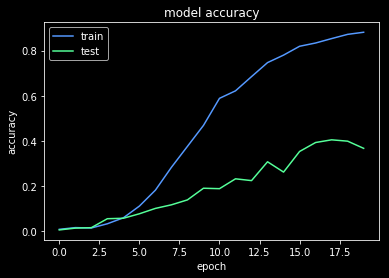

In [95]:
import matplotlib.pyplot as plt

plt.style.use('dark_background')

plt.plot(train_result.history['acc'], color="#5599FF")
plt.plot(train_result.history['val_acc'], color="#55FF99")
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()